In [1]:
# %pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import numpy as np
from scipy.integrate import solve_ivp
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("../dados/bat_data.csv",header=0)
df2 = pd.read_csv("../dados/bat_data2.csv",header=0)
df

,apa_t,apa_mm,amox_t,amox_mm,ester_t,ester_mm,aoh_t,aoh_mm
0,0.0,60.00000,0.0,0.000000,0.0,20.000000,0.0,0.000000
1,30.0,59.81431,30.0,0.155106,30.0,18.986957,30.0,0.822901
2,60.0,59.73249,60.0,0.215833,60.0,18.747155,60.0,0.973603
3,90.0,59.80909,90.0,0.282864,90.0,18.369786,90.0,1.184325
4,120.0,59.65543,120.0,0.458630,120.0,17.961840,120.0,1.272074
5,187.5,59.59763,187.5,0.603443,187.5,17.285627,187.5,1.636247
6,240.0,59.38548,240.0,0.725315,240.0,16.719786,240.0,1.888615
7,300.0,59.28374,300.0,0.911769,300.0,16.075576,300.0,2.266852
8,360.0,58.99810,360.0,1.188997,360.0,15.035050,360.0,2.752346
9,420.0,58.73914,420.0,1.387558,420.0,14.085256,420.0,3.340910


In [3]:
CAB_medida1  = df.loc[:,'ester_mm'].dropna().to_numpy(dtype=float)
CAN_medida1 = df.loc[:,'amox_mm'].dropna().to_numpy(dtype=float)
CNH_medida1 = df.loc[:,'apa_mm'].dropna().to_numpy(dtype=float)
CAOH_medida1 = df.loc[:,'aoh_mm'].dropna().to_numpy(dtype=float)
t1 = df.loc[:,'ester_t'].dropna().to_numpy(dtype=float)

experimental_data1 = np.array((CAB_medida1, CAN_medida1, CNH_medida1, CAOH_medida1))
tempo_substratos1 = t1
tempo_produtos1 = t1
experimental_data1.shape


(4, 11)

In [4]:
CAB_medida2  = df2.loc[:,'ester_mm'].dropna().to_numpy(dtype=float)
CAN_medida2 = df2.loc[:,'amox_mm'].dropna().to_numpy(dtype=float)
CNH_medida2 = df2.loc[:,'apa_mm'].dropna().to_numpy(dtype=float)
CAOH_medida2 = df2.loc[:,'aoh_mm'].dropna().to_numpy(dtype=float)
t2 = df2.loc[:,'ester_t'].dropna().to_numpy(dtype=float)

experimental_data2 = np.array((CAB_medida2, CAN_medida2, CNH_medida2, CAOH_medida2))
tempo_substratos2 = t2
tempo_produtos2 = t2

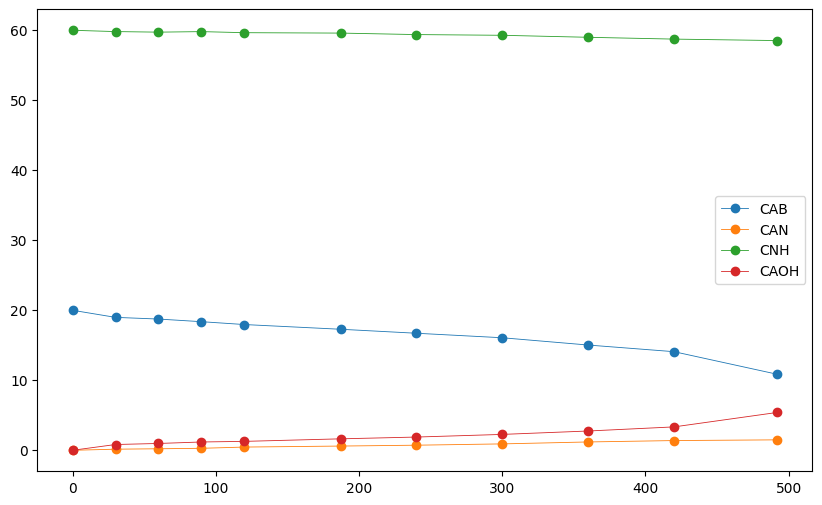

In [5]:
fig = plt.figure(figsize=(10,6))
plt.plot(t1,CAB_medida1,'-o',linewidth=0.6)
plt.plot(t1,CAN_medida1,'-o',linewidth=0.6)
plt.plot(t1,CNH_medida1,'-o',linewidth=0.6)
plt.plot(t1,CAOH_medida1,'-o',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])

In [6]:
Cez = 1
CI1 = np.array([CAB_medida1[0],CAN_medida1[0],CNH_medida1[0],CAOH_medida1[0]])
CI2 = np.array([CAB_medida2[0],CAN_medida2[0],CNH_medida2[0],CAOH_medida2[0]])

In [7]:
def enzymic_amox_bat(t,y, 
k2,
k3,
k4,
k5,
KS,
KP,
KN,
kmenos4,
):
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    RP = (Cez)/(k3 * KN + k4 * CNH + k5 * CNH) * ((k2 * k4 * CAB * CNH)/ (KS) - (kmenos4 * CAN * (k3 * KN + k5 * CNH)/KP))
    RB = Cez * (k3 * KN + k5 * CNH) / (k3 * KN + k4 * CNH + k5 * CNH) * ((k2 * CAB) / KS - (kmenos4 * CAN) / KP)
    RS = -(RP + RB)
    RNu = -(RP)

    dy = np.zeros(4)

    dy[0] =  RS       
    dy[1] =  RP
    dy[2] =  -(RP)  
    dy[3] = RB      
    
    return np.array(dy)        

In [8]:
Cez = 1

k2 = 0.1 
k3 = 2
k4 = 0.3
k5 = 0.4
KS = 5.0
KP = 0.9
KN = 4.0
kmenos4 = 0.01
P = np.zeros(8)
P[0]   = k2 
P[1]   = k3    
P[2]   = k4      
P[3]   = k5      
P[4]   = KS     
P[5]   = KP      
P[6]   = KN      
P[7]   = kmenos4

Np = len(P)



In [9]:
def ode15s_amox(P, CI, t):
    result = scipy.integrate.solve_ivp(enzymic_amox_bat,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P)
    if result.status == -1:
        return np.random.random((CI.shape[0],len(t))) * 1000
    return scipy.integrate.solve_ivp(enzymic_amox_bat,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P).y

In [10]:
def calculate_error(model_output, experimental_data):
    total_error = np.sum((model_output - experimental_data) ** 2)
    print(total_error,end="\r")
    return total_error

In [11]:
def objective_function(params):
    sol1 = ode15s_amox(params,CI1,t1)
    sol2 = ode15s_amox(params,CI2,t2)
    model_output1 = sol1
    model_output2 = sol2
    return (calculate_error(model_output1,experimental_data1) + calculate_error(model_output2,experimental_data2),)


In [12]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

param_bounds = [(0.01,0.15), (0.01, 20), (0.03, 1.5), (0.01, 2), (3, 20), (0.01,5), (0.01,5),(0.002,0.02)]
def create_individual():
    return creator.Individual([np.random.uniform(low, high) for low, high in param_bounds])

toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", objective_function)

In [13]:
population = toolbox.population(n=50)
n_generations = 200

# Statistics to keep track of the optimization process
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

In [14]:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, 
                                            stats=stats, verbose=True)

gen	nevals	avg    	min   	max    
0  	50    	17334.4	1468.1	49374.5
1  	35    	1.52795e+06	849.259	2.92782e+07
2  	38    	1.08487e+06	847.887	2.71837e+07
3  	27    	7.5647e+55 	694.898	3.78235e+57
4  	30    	2510.62    	694.898	17746.9    
5  	33    	541417     	694.898	2.69308e+07
6  	31    	611676     	642.461	3.04698e+07
7  	32    	23522.3    	559.339	1.07147e+06
8  	27    	474050     	559.339	2.35659e+07
9  	20    	274126     	559.339	1.36221e+07
10 	30    	289704     	559.339	1.43878e+07
11 	30    	1.07777e+06	559.339	2.73479e+07
12 	29    	1.21695e+10	559.339	6.08473e+11
13 	35    	132063     	559.339	6.53332e+06
14 	23    	559632     	556.734	2.79322e+07
15 	33    	517275     	556.106	2.57573e+07
16 	25    	716.324    	556.106	4720.16    
17 	28    	3771.77    	554.09 	159990     
18 	29    	558.748    	554.09 	575.32     
19 	31    	558.189    	553.993	585.82     
20 	27    	613801     	553.993	3.06402e+07
21 	29    	724.01     	553.72 	8995.11    
22 	26    	295819     	552.66

In [20]:
best_individual = tools.selBest(population, k=1)[0]
print("Best individual is: %s\nwith fitness: %s" % (best_individual, best_individual.fitness.values))

Best individual is: [0.023278513049309852, 16.4787744276794, 0.9473560062838432, 0.41770493721562935, 11.623095434854019, 2.590295994408647, 2.206297379111438, 0.0024287547332715463]
with fitness: (545.8040198117176,)


In [21]:
P_new = np.array(best_individual)

In [22]:
labels = ['k2',
'k3',
'k4',
'k5',
'KS',
'KP',
'KN',
'kmenos4']
for i in range(len(labels)):
    print(labels[i],': ',P_new[i])

k2 :  0.023278513049309852
k3 :  16.4787744276794
k4 :  0.9473560062838432
k5 :  0.41770493721562935
KS :  11.623095434854019
KP :  2.590295994408647
KN :  2.206297379111438
kmenos4 :  0.0024287547332715463


In [24]:
sol1 = ode15s_amox(P_new,CI1,t1)
CAB1  = sol1[0]
CAN1  = sol1[1] 
CNH1 = sol1[2]
CAOH1 = sol1[3]

sol2 = ode15s_amox(P_new,CI2,t2)
CAB2  = sol2[0]
CAN2  = sol2[1] 
CNH2 = sol2[2]
CAOH2 = sol2[3]

In [25]:
results_dir = f"../results/GA_bat_model_2"

names = ['Ester','6-APA','AMOX','POHPG']
medidas = [
    [CAB_medida1,CAB1],
    [CNH_medida1,CNH1],
    [CAN_medida1,CAN1],
    [CAOH_medida1,CAOH1]
]
for name, medida in zip(names, medidas):
    plt.plot(t1, medida[0], 'ob', label='Medida')
    plt.plot(t1, medida[1], '-ok', label='Estimada')
    plt.xlabel('Tempo (h)')
    plt.ylabel(f"Concentração de {name} (g/L)")
    plt.legend() # Adjust legend position
    plt.title(f"Concentração de {name} ao Longo do Tempo")
    plt.savefig(f"{results_dir}/{name}_estimate.png", dpi=400)
    plt.close()  # Close the figure to release memory

In [26]:
results_dir = f"../results/GA_bat_model_2"

names = ['Ester','6-APA','AMOX','POHPG']
medidas = [
    [CAB_medida2,CAB2],
    [CNH_medida2,CNH2],
    [CAN_medida2,CAN2],
    [CAOH_medida2,CAOH2]
]
for name, medida in zip(names, medidas):
    plt.plot(t2, medida[0], 'ob', label='Medida')
    plt.plot(t2, medida[1], '-ok', label='Estimada')
    plt.xlabel('Tempo (h)')
    plt.ylabel(f"Concentração de {name} (g/L)")
    plt.legend() # Adjust legend position
    plt.title(f"Concentração de {name} ao Longo do Tempo")
    plt.savefig(f"{results_dir}/{name}_estimate2.png", dpi=400)
    plt.close()  # Close the figure to release memory

Text(0, 0.5, 'mM')

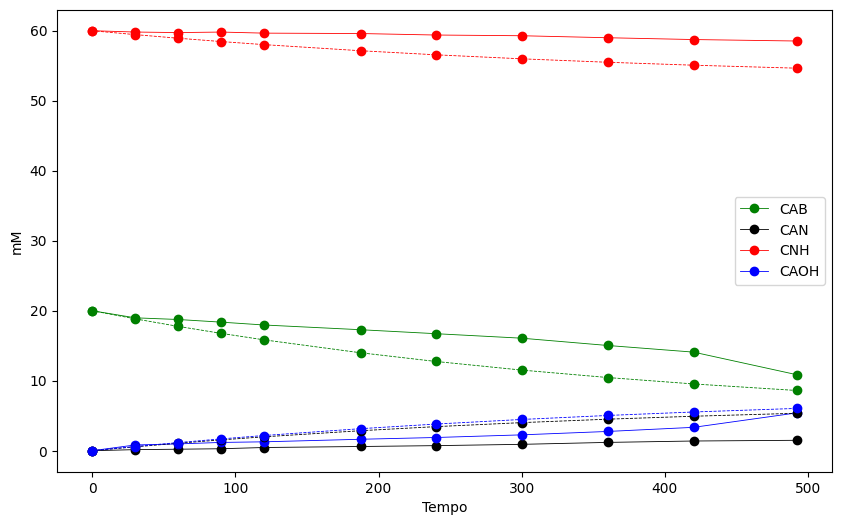

In [27]:
fig = plt.figure(figsize=(10,6))
plt.plot(t1,CAB_medida1,'-og',linewidth=0.6)
plt.plot(t1,CAN_medida1,'-ok',linewidth=0.6)
plt.plot(t1,CNH_medida1,'-or',linewidth=0.6)
plt.plot(t1,CAOH_medida1,'-ob',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])
plt.plot(t1, CAB1,'--og',linewidth=0.6)
plt.plot(t1, CAN1,'--ok',linewidth=0.6)
plt.plot(t1, CNH1,'--or',linewidth=0.6)
plt.plot(t1, CAOH1,'--ob',linewidth=0.6)
plt.xlabel('Tempo')
plt.ylabel('mM')

Text(0, 0.5, 'mM')

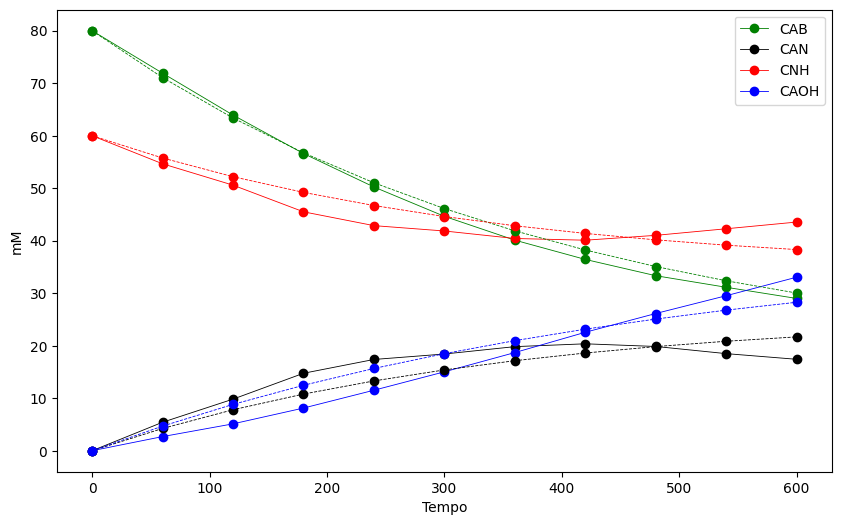

In [28]:
fig = plt.figure(figsize=(10,6))
plt.plot(t2,CAB_medida2,'-og',linewidth=0.6)
plt.plot(t2,CAN_medida2,'-ok',linewidth=0.6)
plt.plot(t2,CNH_medida2,'-or',linewidth=0.6)
plt.plot(t2,CAOH_medida2,'-ob',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])
plt.plot(t2, CAB2,'--og',linewidth=0.6)
plt.plot(t2, CAN2,'--ok',linewidth=0.6)
plt.plot(t2, CNH2,'--or',linewidth=0.6)
plt.plot(t2, CAOH2,'--ob',linewidth=0.6)
plt.xlabel('Tempo')
plt.ylabel('mM')